Part 1

In [1]:
# Load the libraries needed
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Seed random number generator
np.random.seed(123)

# Helper functions for polynomials
def powers( X, n ):
    """ Returns an array of the powers of the elements of X up to the nth power """
    return np.power(np.expand_dims(X, axis=-1), [np.arange(n)])

def polynomial( X, poly_coeff ):
    """ Returns the value of a polynomial at x with given coefficients """
    deg = np.shape(poly_coeff)[-1]
    return np.dot(powers(X, deg), np.transpose(poly_coeff), )

def fit_polynomial( X, y, n ):
    """ Returns the coefficients of the n-degree polynomial fit to (X, y) """
    X_pwrs = powers(X, n+1)
    # Do linear least squares fit
    coeff, _, _, _ = np.linalg.lstsq(X_pwrs, y, rcond=None)
    return coeff

def degree( poly_coeff ):
    """ Returns the degree of a polynomial from its coefficients """
    return len(poly_coeff)-1

In [2]:
def rss_loss(X, y, learned_coeff):
    """ Computes the residual sum of squares loss for a given polynomial on the given data """
    pred_y = polynomial(X, learned_coeff)
    return np.sum(np.square(pred_y - y))
    
def aic_loss(X, y, learned_coeff):
    """ Computes the Akaike’s Information Criterion for a given polynomial on the given data """
    AIC = (rss_loss(X,y,learned_coeff) + 2 * (degree(learned_coefficients)+1))/np.shape(X)[0]
    return AIC
    
def bic_loss(X, y, learned_coeff):
    """ Computes the Bayesian Information Criterion for a given polynomial on the given data """
    BIC = (rss_loss(X,y,learned_coeff) + ((degree(learned_coefficients)+1) * math.log(np.shape(X)[-1])))/np.shape(X)[0]
    return BIC

Part 1. Assignment 1

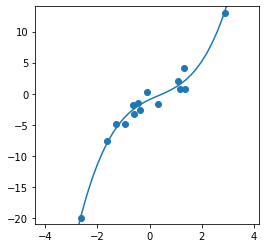

Fitted a degree 3 polynomial with RSS loss: 15.57, AIC loss: 1.57, BIC loss: 1.76 to 15 datapoints.


In [3]:
# Load data
X, y = np.load("./class9_generated_data.npy", allow_pickle=True)

#Plot the data
plt.figure(figsize=(4,4))
plt.scatter(X,y)
plt.ylim(y.min()-1., y.max()+1.)

# Make sequence of x-values for plotting
axis_X = np.arange(-4.0, 4.0, 0.2)

# Fit a polynomial
n = 3
learned_coefficients = fit_polynomial( X, y, n )

#Plot the learned polynomial
poly_y = polynomial(axis_X, learned_coefficients)
plt.plot(axis_X, poly_y, )

plt.show()

num_points = np.shape(X)[0]
rss = rss_loss(X, y, learned_coefficients)
aic = aic_loss(X, y, learned_coefficients)
bic = bic_loss(X, y, learned_coefficients)
str_ = "Fitted a degree {:d} polynomial with ".format(degree(learned_coefficients))
str_ += "RSS loss: {:.2f}, AIC loss: {:.2f}, BIC loss: {:.2f} ".format(rss, aic, bic)
print(str_ + "to {:d} datapoints.".format(num_points))


In [4]:
def linear ( X, coefficients ):
    # Add a vector of ones to take care of the intercept.
    X = np.concatenate([X,np.ones((X.shape[0],1))],axis=1)
    return np.dot(X, np.transpose(coefficients), )

def fit_linear( X, y, features=None ):
    """ 
        Returns the coefficients of a linear model fit to X,y.
        If features is a list of integers, then fit will ignore
        any features whose index is not in the list.
        ( Returned coefficients for these features will be set
        to 0. )
    """
    # Add a vector of ones to take care of the intercept.
    X = np.concatenate([X,np.ones((X.shape[0],1))],axis=1)         
    if features is not None:
        # Make a mask
        tot_num_features = np.shape(X)[-1]
        mask = np.zeros((1,tot_num_features))
        mask[0,features] = 1.
        # Zero out all irrellevant features
        X = X * mask
    
    # Do linear least squares fit
    coeff, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    return coeff

In [5]:
# Load data
data = []
continuous_features = np.array ([ 0, 1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25 ])
train_features = np.array([1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24, 25 ])
# Original data is from https://archive.ics.uci.edu/ml/datasets/automobile
with open('./automobile.csv', 'r', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='\"')
    for row in csvreader:
        try:
            # Get all continuous rows
            data.append([float(row[i]) for i in continuous_features])
        except:
            continue # skip this row since data-processing failed

data = np.array(data)
y = data[:, 0] # target is first value
X = data[:, 1:] # training data is the rest

# Normalize the data to zero mean and unit std
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)
y = (y - np.mean(y)) / np.std(y)

print("Sucessfully loaded {:d} entries.\n".format(len(X)))

Sucessfully loaded 160 entries.



Part 1 Assignment 2

In [6]:
# Forwards stepwise feature selection
tot_num_features = np.shape(X)[-1]
all_features = range(tot_num_features)
curr_features = []

best_score = 1e9
best_features = None

print("Performing forwards stepwise feature selection using mean AIC as criteria...")
# While we have remaining features...
while len(curr_features) != tot_num_features:
    # Get remaining features 
    candidate_features = [ f for f in all_features if f not in curr_features ]
    
    best_score_this_round = 1e9
    best_feature_this_round = None
    
    for f in candidate_features:
        test_features = curr_features + [f]
        
        learned_coefficients = fit_linear( X, y, test_features )
        
        y_pred = linear(X, learned_coefficients)
    
        rssloss = np.sum(np.square(y_pred - y))
        
        AIC = (rssloss + 2 * (len(test_features)+1))/np.shape(X)[0]
    
        score = AIC 

        # Remember, lower score is better
        if score < best_score_this_round:
            best_score_this_round = score
            best_feature_this_round = f
            
        if score < best_score:
            best_score = score
            best_features = test_features
            
    # Set current features to best features from round
    curr_features = curr_features + [best_feature_this_round]
    print("Round {}, selected feature {:d} with AIC score {:.3f}"\
          .format(len(curr_features), continuous_features[best_feature_this_round], best_score_this_round ))
            
print("Feature Index: {} Best features no. were {} ({:d} total) with score {:.3f}".format(best_features ,train_features[best_features], len(best_features), best_score))

Performing forwards stepwise feature selection using mean AIC as criteria...
Round 1, selected feature 1 with AIC score 0.754
Round 2, selected feature 0 with AIC score 0.530
Round 3, selected feature 10 with AIC score 0.490
Round 4, selected feature 9 with AIC score 0.498
Round 5, selected feature 19 with AIC score 0.506
Round 6, selected feature 22 with AIC score 0.516
Round 7, selected feature 23 with AIC score 0.517
Round 8, selected feature 11 with AIC score 0.528
Round 9, selected feature 20 with AIC score 0.539
Round 10, selected feature 12 with AIC score 0.550
Round 11, selected feature 21 with AIC score 0.560
Round 12, selected feature 13 with AIC score 0.572
Round 13, selected feature 16 with AIC score 0.584
Round 14, selected feature 24 with AIC score 0.596
Round 15, selected feature 18 with AIC score 0.608
Feature Index: [1, 0, 3] Best features no. were [ 9  1 11] (3 total) with score 0.490


Part 1 Assignment 2

In [7]:
curr_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
overall_best_score = 1e9
overall_best_features = None 
count = 0
while len(curr_features) != 0:

    best_score = 1e9
    best_features = None
    
    for f in curr_features:
        test = curr_features.copy()
        test.remove(f)

        learned_coefficients = fit_linear( X, y, test )
        
        y_pred = linear(X, learned_coefficients)
        
        rssloss = np.sum(np.square(y_pred - y))
        
        AIC = (rssloss + 2 * (len(test)+1))/np.shape(X)[0]
        
        score = AIC

        if score < best_score:
            best_score = score
            best_features = test
            best_feature = f
        
        if score < overall_best_score:
            overall_best_score = score
            overall_best_features = test

    
    curr_features = best_features
    
    count += 1
    
    print("Round {}, removed feature {:d}, round AIC score {:.3f}".format(count,train_features[best_feature], best_score))
#print(overall_best_score,overall_best_features)
print("Feature Index: {} Best features no. {} ({} total) with AIC score {:.3f}".format(overall_best_features,train_features[overall_best_features],len(overall_best_features),overall_best_score))

Round 1, removed feature 19, round AIC score 0.596
Round 2, removed feature 25, round AIC score 0.584
Round 3, removed feature 10, round AIC score 0.571
Round 4, removed feature 18, round AIC score 0.559
Round 5, removed feature 16, round AIC score 0.548
Round 6, removed feature 22, round AIC score 0.538
Round 7, removed feature 13, round AIC score 0.527
Round 8, removed feature 21, round AIC score 0.516
Round 9, removed feature 12, round AIC score 0.505
Round 10, removed feature 20, round AIC score 0.502
Round 11, removed feature 24, round AIC score 0.502
Round 12, removed feature 23, round AIC score 0.490
Round 13, removed feature 11, round AIC score 0.530
Round 14, removed feature 1, round AIC score 0.754
Round 15, removed feature 9, round AIC score 1.012
Feature Index: [0, 1, 3] Best features no. [ 1  9 11] (3 total) with AIC score 0.490


In [8]:
#AIC score for LASSO Coefficients
LASSO_coefs = [0,1,3,9,10,11]

learned_coefficients = fit_linear( X, y, LASSO_coefs )

y_pred = linear(X, learned_coefficients)

rssloss = np.sum(np.square(y_pred - y))

AIC = (rssloss+ 2*(len(LASSO_coefs)+1))/np.shape(X)[0]

print(AIC)

0.5186618874853988


In [9]:
AIC_features = [0,1,3]
coefs = fit_linear( X, y, AIC_features )
coefs

array([ 0.42168113, -0.83176155,  0.        ,  0.41459772,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])